# 0. 사용할 패키지 불러오기

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model
import cv2


/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/ten

# 1. 데이터 불러오기

In [3]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 320, 120, 1))
y_train = np.empty((0, 3))
print(y_train.shape)

training_data = glob.glob('/home/pirl/Documents/final_lane_datas/final/*.npz')
#print(training_data)

for single_npz in training_data:
    with np.load(single_npz) as data:
        #print(data.files)
        x = data['train']
        y = data['train_labels']
        temp=cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) # convert color to gray
        #print(x.shape,temp.shape)
    x = np.reshape(temp, ( -1, 320, 120, 1))
    
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))


print(x_train.shape)
# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:]
y_test = y_test[:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(0, 3)
(2927, 320, 120, 1)
(2048, 320, 120, 1) (2048, 3)
(879, 320, 120, 1) (879, 3)


# 데이터 확인

In [4]:
#import pandas as pd

#y_data = pd.DataFrame(y_total[:, :])

In [5]:
#y_data.count()

In [6]:
#left = y_data.loc[y_data[:][0] == 1]

In [7]:
#left.count()

In [8]:
#right = y_data.loc[y_data[:][1] == 1]

In [9]:
#right.count()

In [10]:
#forward = y_data.loc[y_data[:][2] == 1]

In [11]:
#forward.count()

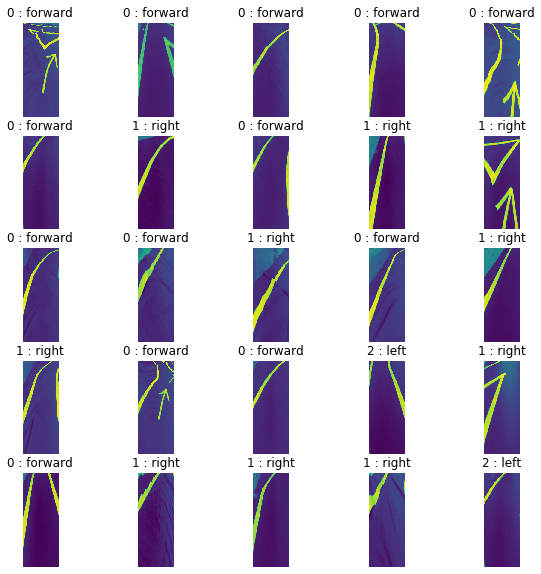

In [12]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(320, 120))
    
    label = np.argmax(y_train[i])
                      
    if label == 2 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 0:
        direction = 'forward'
#     elif label == 3:
#         direction = 'backward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [13]:
# image size = 160 x 320
def posla_net():
    
    # model setting
    H = 320
    W = 120
    CH = 1

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model

In [14]:
model = posla_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 318, 118, 3)       30        
_________________________________________________________________
batch_normalization (BatchNo (None, 318, 118, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 159, 59, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 157, 57, 9)        252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 78, 28, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 76, 26, 18)        1476      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 13, 18)        0         
__________

In [15]:
# from tensorflow.python.keras.utils import plot_model
# plot_model(model, to_file= 'video_net_plot.png', show_shapes = True, show_layer_names = True)

# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [16]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [19]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [20]:
EPOCHS = 60
INIT_LR = 1e-3
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [21]:
from tensorflow.keras.utils import to_categorical


In [22]:
y_binary = to_categorical(y_train)

In [23]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 1638 samples, validate on 410 samples
Epoch 1/60


InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 8370061312

In [ ]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [24]:
#l_model = load_model('./model_data/VGG_model.h5')

In [65]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

676/676 [==============================] - 0s 265us/step
## evaluation loss and_metrics ##
[0.2614900186746078, 0.9363905321916884]


In [66]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 0, Predict : 0
True : 1, Predict : 1


# 7. 최종 모델 훈련

In [67]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(2253, 320, 120, 1)
(2253, 3)


In [68]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [69]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [70]:
EPOCHS = 60
INIT_LR = 1e-3
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


In [35]:
# EPOCHS = 100
# INIT_LR = 1e-4
# BS = 256
# split_ratio = 0.2

# print("[INFO] compiling model...")
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# model.compile(loss="categorical_crossentropy", optimizer=opt,
#     metrics=["accuracy"])

[INFO] compiling model...


In [71]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Epoch 1/60
2253/2253 [==============================] - 2s 901us/step - loss: 0.3866 - acc: 0.8926
Epoch 2/60
2253/2253 [==============================] - 1s 358us/step - loss: 0.4125 - acc: 0.8673
Epoch 3/60
2253/2253 [==============================] - 1s 363us/step - loss: 0.4052 - acc: 0.8660
Epoch 4/60
2253/2253 [==============================] - 1s 359us/step - loss: 0.3607 - acc: 0.8673
Epoch 5/60
2253/2253 [==============================] - 1s 342us/step - loss: 0.3215 - acc: 0.8793
Epoch 6/60
2253/2253 [==============================] - 1s 353us/step - loss: 0.2751 - acc: 0.8997
Epoch 7/60
2253/2253 [==============================] - 1s 336us/step - loss: 0.2593 - acc: 0.8975
Epoch 8/60
2253/2253 [==============================] - 1s 366us/step - loss: 0.2709 - acc: 0.9001
Epoch 9/60
2253/2253 [==============================] - 1s 353us/step - loss: 0.2723 - acc: 0.9032
Epoch 10/60
2253/2253 [==============================] - 1s 346us/step - loss: 0.2666 - acc: 0.9024
Epoch 11/

In [75]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

676/676 [==============================] - 0s 230us/step
## evaluation loss and_metrics ##
[0.021682135027849814, 0.989644971824962]


In [73]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 2, Predict : 2
True : 0, Predict : 0
True : 1, Predict : 1
True : 1, Predict : 1
True : 0, Predict : 0
True : 0, Predict : 0
True : 0, Predict : 0
True : 0, Predict : 0
True : 1, Predict : 1
True : 0, Predict : 0


# 8. 모델 저장

In [35]:
#model.save('./model_data/video_model_3.h5')

Saved model to disk
